In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import *
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import plot_tree
import lime
import lime.lime_tabular

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<font color="bluegrey" size=+1.0><b>Data Preprocessing</b></font>

In [5]:
# Handle missing values
data["bmi"].fillna(data["bmi"].mean(), inplace=True)

# Integrate threshold-based logic
data["gender_stroke_risk"] = data["gender"].apply(lambda x: 1 if x.lower() == "female" else 0)
data["age_stroke_risk"] = data["age"].apply(lambda x: 1 if x >= 25 else 0)
data["hypertension_stroke_risk"] = data["hypertension"]
data["heart_disease_stroke_risk"] = data["heart_disease"]
data["ever_married_stroke_risk"] = data["ever_married"].apply(lambda x: 0 if x.lower() == "yes" else 1)
data["work_type_stroke_risk"] = data["work_type"].apply(lambda x: 1 if x in ["Private", "Self-employed"] else 0)
data["residence_stroke_risk"] = data["Residence_type"].apply(lambda x: 1 if x.lower() == "rural" else 0)
data["glucose_stroke_risk"] = data["avg_glucose_level"].apply(lambda x: 1 if 126 <= x <= 139.9 else 0)
data["bmi_stroke_risk"] = data["bmi"].apply(lambda x: 1 if x < 18.5 or x >= 30 else 0)
data["smoking_stroke_risk"] = data["smoking_status"].apply(lambda x: 1 if x.lower() == "smokes" else 0)

# Step 2: Sum the risk columns to get a final risk score
data["stroke_risk_score"] = (data[[
    "gender_stroke_risk",
    "age_stroke_risk",
    "hypertension_stroke_risk",
    "heart_disease_stroke_risk",
    "ever_married_stroke_risk",
    "work_type_stroke_risk",
    "residence_stroke_risk",
    "glucose_stroke_risk",
    "bmi_stroke_risk",
    "smoking_stroke_risk"
]]).sum(axis=1)

# Step 3: Define a threshold to classify risk of stroke
# For example, if the score is 3 or more, consider at risk (1), otherwise not at risk (0)
threshold = 3
data["final_stroke_risk"] = data["stroke_risk_score"].apply(lambda x: 1 if x >= threshold else 0)

C:\Users\zen\AppData\Local\Temp\ipykernel_40124\2973005153.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["bmi"].fillna(data["bmi"].mean(), inplace=True)


<font color="bluegrey" size=+1.0><b>Decision Tree</b></font>

Accuracy: 0.9099804305283757
Confusion Matrix:
 [[920  52]
 [ 40  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.16      0.20      0.18        50

    accuracy                           0.91      1022
   macro avg       0.56      0.57      0.57      1022
weighted avg       0.92      0.91      0.91      1022



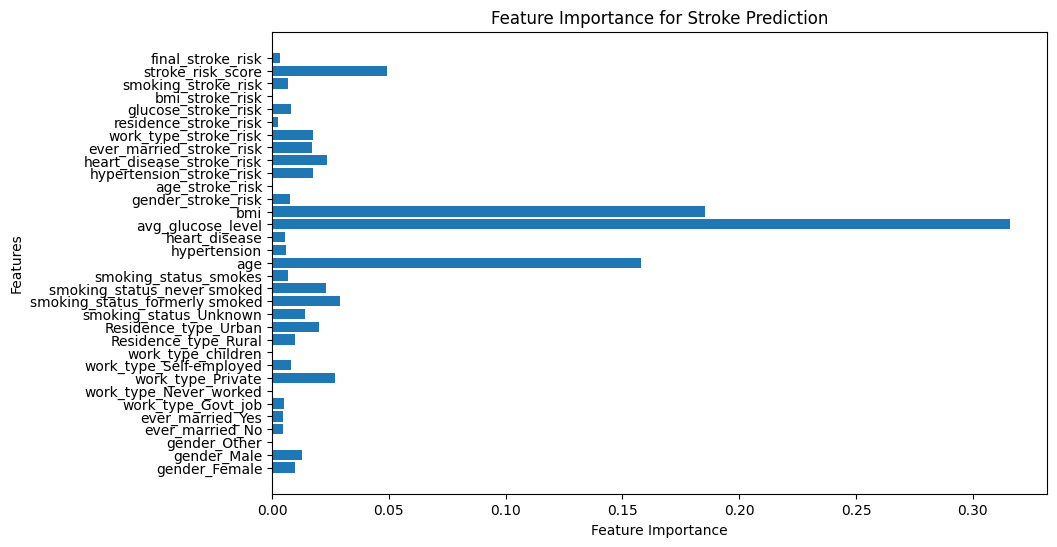

ValueError: could not convert string to float: 'Male'

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

# Create a full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_model)
])

# Split the dataset into training and testing sets (80% training, 20% testing)
X = data.drop(columns=['stroke', 'id'])
y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

onehot_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_columns)
all_feature_names = list(onehot_columns) + [col for col in X.select_dtypes(include=['float64', 'int64']).columns]

# LIME: Create a LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X.columns, 
    class_names=['No Stroke', 'Stroke'], 
    mode='classification', 
    discretize_continuous=True
)

# Select an instance to explain
i = 0  # Choose the index of the instance in the test set you want to explain
exp = explainer.explain_instance(X_test.iloc[i].values, dt_model.predict_proba)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Plot the explanation
exp.as_pyplot_figure()
plt.show()

# Plot the feature importance from the model itself (for general feature importance)
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(all_feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Stroke Prediction')
plt.show()

<font color="bluegrey" size=+1.0><b>Logistic Regression</b></font>

In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(lr_model, X_resampled, y_resampled, scoring='accuracy', cv=skf)
print("Logistic Regression Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Evaluate the model
y_pred = lr_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

# SHAP Explanation
explainer = shap.LinearExplainer(lr_model, X_train)
shap_values = explainer.shap_values(X_test)

# Global SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# SHAP Force Plot for a Specific Instance
shap.force_plot(explainer.expected_value[1], shap_values[instance_idx], X_test.iloc[instance_idx], feature_names=X.columns)

<font color="bluegrey" size=+1.0><b>Naive-Bayes</b></font>

In [ ]:
nb_model = GaussianNB()

# Cross-validation
cv_scores = cross_val_score(nb_model, X_resampled, y_resampled, scoring='accuracy', cv=skf)
print("Naive Bayes Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Train the model
nb_model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = nb_model.predict(X)
print("Naive Bayes Classification Report:")
print(classification_report(y, y_pred))

# XAI with SHAP
explainer = shap.Explainer(nb_model, X_resampled)
shap_values = explainer(X_resampled)

# Global Feature Importance
shap.summary_plot(shap_values, X_resampled, plot_type="bar")

# Local Explanation for a specific instance
shap.force_plot(explainer.expected_value[1], shap_values[0], feature_names=X.columns)

<font color="bluegrey" size=+1.0><b>K-Neighbours</b></font>

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

# Cross-validation
cv_scores = cross_val_score(knn_model, X_resampled, y_resampled, scoring='accuracy', cv=skf)
print("KNN Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Train the model
knn_model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = knn_model.predict(X)
print("KNN Classification Report:")
print(classification_report(y, y_pred))

# XAI with SHAP
explainer = shap.Explainer(knn_model, X_resampled)
shap_values = explainer(X_resampled)

# Global Feature Importance
shap.summary_plot(shap_values, X_resampled, plot_type="bar")

# Local Explanation for a specific instance
instance = X.iloc[0]
shap.force_plot(explainer.expected_value[1], shap_values[0], feature_names=X.columns)